In [3]:
!pip install geopandas
!pip install rasterio
# Imports
import xarray as xr
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, LineString
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.1 MB/s eta 0:00:00


In [4]:
# Paths
root       = Path('/content/drive/MyDrive/Flood_Thesis/Data')
land_nc    = root / 'ERA5_Data/Fine_ERA5/tp_ERA5Land_2017_2019.nc'
dem_path   = root / 'static_data/srtm-cgiar-nepal-boundary-dem-90m/' \
                  'srtm_cgiar_nepal_boundary.img'
flood_dir  = root / 'Flood_labels'
shp_path   = root / 'kathmandu valley border/kathmandu valley border.shp'

In [5]:
# Load boundary
valley = gpd.read_file(shp_path).to_crs(epsg=4326)

In [6]:
# A) Build the 5×5 0.1° tiles
ds0 = xr.open_dataset(land_nc, engine='h5netcdf')
lats, lons = ds0.latitude.values, ds0.longitude.values
ds0.close()

In [7]:
half = 0.05
tiles = []
for latc in lats:
    for lonc in lons:
        tiles.append({
            'lat_center': latc,
            'lon_center': lonc,
            'geometry': box(lonc-half, latc-half, lonc+half, latc+half)
        })
tiles_gdf = gpd.GeoDataFrame(tiles, crs='EPSG:4326')

In [8]:
#  Static Slope per tile (DEM at 90 m)
with rasterio.open(dem_path) as src:
    dem_clip, transform = mask(src, [valley.geometry.unary_union], crop=True)
dem = dem_clip[0].astype('float32')

<ipython-input-8-a1acc2803277>:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dem_clip, transform = mask(src, [valley.geometry.unary_union], crop=True)


In [9]:
# Approximate 90 m spacing
dz_dy, dz_dx = np.gradient(dem, 90, 90)
slope = np.degrees(np.arctan(np.hypot(dz_dx, dz_dy)))

In [11]:
# Build pixel‐center grids for the clipped DEM
rows, cols = dem.shape

# Unpack the affine transform properly
a = transform.a
b = transform.b
c = transform.c
d = transform.d
e = transform.e
f = transform.f

# Compute the x (lon) and y (lat) coordinates of each pixel center
xs = c + (np.arange(cols) + 0.5) * a
ys = f + (np.arange(rows) + 0.5) * e

# Make 2D arrays for masking/aggregation
lon2d, lat2d = np.meshgrid(xs, ys)

In [12]:
static_records = []
for tile in tiles_gdf.itertuples():
    minx, miny, maxx, maxy = tile.geometry.bounds
    mask_tile = (
        (lat2d >= miny) & (lat2d < maxy) &
        (lon2d >= minx) & (lon2d < maxx)
    )
    vals = slope[mask_tile]
    static_records.append({
        'lat_center': tile.lat_center,
        'lon_center': tile.lon_center,
        'mean_slope': np.nanmean(vals),
        'max_slope':  np.nanmax(vals),
        'std_slope':  np.nanstd(vals)
    })
static_df = pd.DataFrame(static_records)
print("Slope stats (0.1°):")
print(static_df.head())

Slope stats (0.1°):
   lat_center  lon_center  mean_slope  max_slope  std_slope
0        27.8       85.15    0.000000   0.000000   0.000000
1        27.8       85.25    5.327571  86.778740  14.209436
2        27.8       85.35   14.558131  88.043785  14.795041
3        27.8       85.45   14.434515  87.761078  15.420812
4        27.8       85.55   11.962014  85.589943  17.805616


In [13]:
# C) Distance-to-river per tile center via Overpass API
west, south, east, north = valley.total_bounds
query = f"""
[out:json][timeout:25];
way["waterway"~"river|stream|canal"]({south},{west},{north},{east});
out geom;
"""
resp   = requests.post("https://overpass-api.de/api/interpreter", data={'data':query})
elems  = resp.json()['elements']
geoms  = [LineString([(pt['lon'],pt['lat']) for pt in el['geometry']])
          for el in elems if el['type']=='way']
rivers = gpd.GeoDataFrame(geometry=geoms, crs='EPSG:4326')
rivers = gpd.clip(rivers, valley)


In [14]:
# Build points
pts = gpd.GeoDataFrame(
    static_df[['lat_center','lon_center']],
    geometry=[Point(lon, lat) for lat,lon in zip(static_df.lat_center, static_df.lon_center)],
    crs='EPSG:4326'
)
# Project and compute
rivers_m = rivers.to_crs(epsg=32644)
pts_m    = pts.to_crs(epsg=32644)
pts['dist_to_river_m'] = pts_m.geometry.apply(lambda p: rivers_m.distance(p).min())
print("\nRiver distance (0.1°):")
print(pts[['lat_center','lon_center','dist_to_river_m']].head())


River distance (0.1°):
   lat_center  lon_center  dist_to_river_m
0        27.8       85.15     10404.178123
1        27.8       85.25      2283.543447
2        27.8       85.35      1863.597076
3        27.8       85.45       549.938190
4        27.8       85.55      1720.235031


In [15]:
# D) Annual flood fraction per tile
flood_records = []
for year in [2017, 2018, 2019]:
    with rasterio.open(flood_dir/f"flood_label_{year}.tif") as src:
        for tile in tiles_gdf.itertuples():
            out, _ = mask(src, [tile.geometry], crop=True, all_touched=True)
            arr = out[0]
            frac = np.count_nonzero(arr>0) / arr.size
            flood_records.append({
                'year': year,
                'lat_center': tile.lat_center,
                'lon_center': tile.lon_center,
                'frac_flooded': frac
            })

flood_df = pd.DataFrame(flood_records)
print("\nFlood fraction (0.1°):")
print(flood_df.head())


Flood fraction (0.1°):
   year  lat_center  lon_center  frac_flooded
0  2017        27.8       85.15      0.283941
1  2017        27.8       85.25      0.294788
2  2017        27.8       85.35      0.233882
3  2017        27.8       85.45      0.268504
4  2017        27.8       85.55      0.289970


In [17]:
# 1️⃣ First merge slope + river
static_river = static_df.merge(
    pts[['lat_center','lon_center','dist_to_river_m']],
    on=['lat_center','lon_center']
)

# 2️⃣ Now merge in the flood labels, only on the spatial keys
final_fine = static_river.merge(
    flood_df,
    on=['lat_center','lon_center'],
    how='left'   # brings in the `year` and `frac_flooded`
)

print(final_fine.head(50))


   lat_center  lon_center  mean_slope  max_slope  std_slope  dist_to_river_m  \
0        27.8       85.15    0.000000    0.00000   0.000000     10404.178123   
1        27.8       85.15    0.000000    0.00000   0.000000     10404.178123   
2        27.8       85.15    0.000000    0.00000   0.000000     10404.178123   
3        27.8       85.25    5.327571   86.77874  14.209436      2283.543447   
4        27.8       85.25    5.327571   86.77874  14.209436      2283.543447   

   year  frac_flooded  
0  2017      0.283941  
1  2018      0.339987  
2  2019      0.140760  
3  2017      0.294788  
4  2018      0.312481  


In [18]:
print(final_fine.head(50))

    lat_center  lon_center  mean_slope  max_slope  std_slope  dist_to_river_m  \
0         27.8       85.15    0.000000   0.000000   0.000000     10404.178123   
1         27.8       85.15    0.000000   0.000000   0.000000     10404.178123   
2         27.8       85.15    0.000000   0.000000   0.000000     10404.178123   
3         27.8       85.25    5.327571  86.778740  14.209436      2283.543447   
4         27.8       85.25    5.327571  86.778740  14.209436      2283.543447   
5         27.8       85.25    5.327571  86.778740  14.209436      2283.543447   
6         27.8       85.35   14.558131  88.043785  14.795041      1863.597076   
7         27.8       85.35   14.558131  88.043785  14.795041      1863.597076   
8         27.8       85.35   14.558131  88.043785  14.795041      1863.597076   
9         27.8       85.45   14.434515  87.761078  15.420812       549.938190   
10        27.8       85.45   14.434515  87.761078  15.420812       549.938190   
11        27.8       85.45  

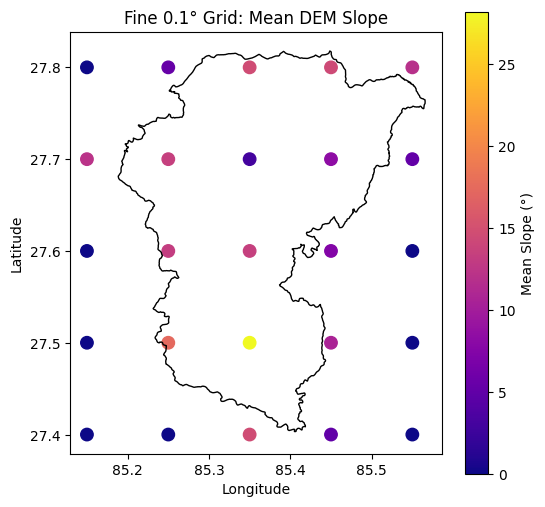

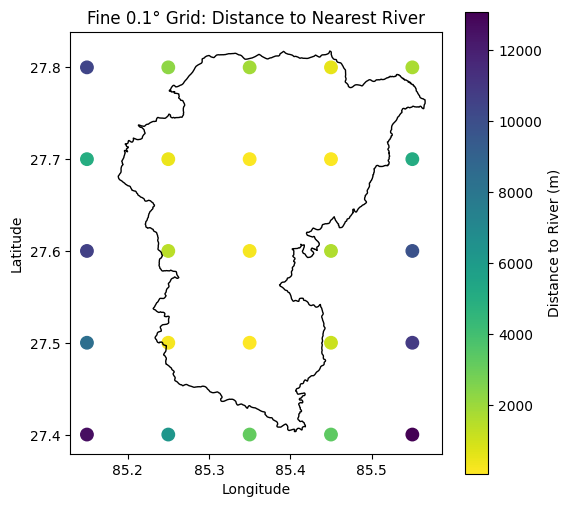

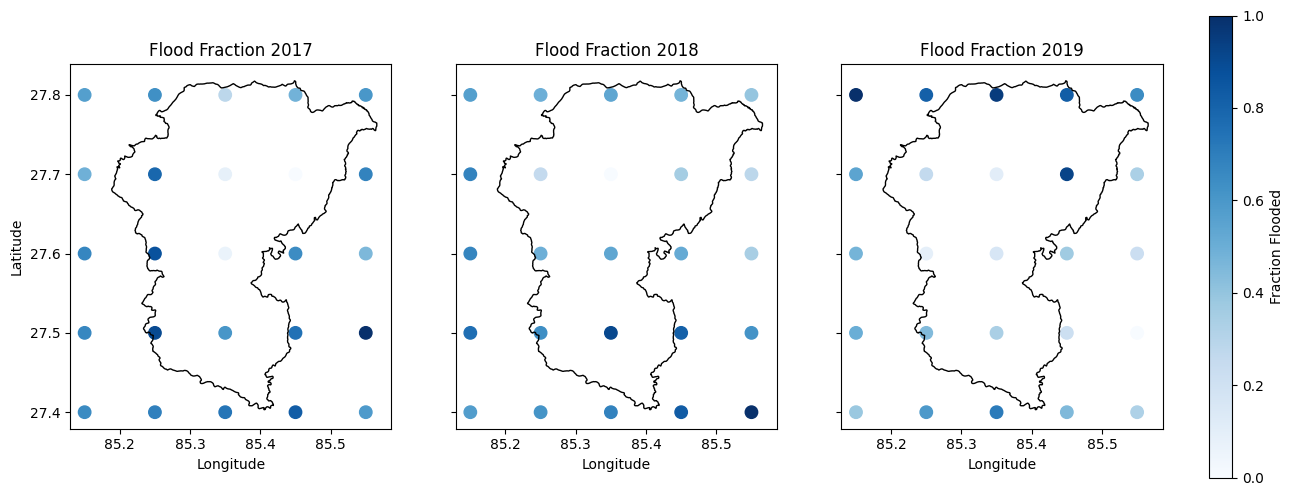

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 1) Extract your Kathmandu boundary (if not already in memory)
from pathlib import Path
root    = Path('/content/drive/MyDrive/Flood_Thesis/Data')
shp     = root/'kathmandu valley border'/'kathmandu valley border.shp'
valley  = gpd.read_file(shp).to_crs(epsg=4326)

# 2) Build a GeoDataFrame of the 25 fine-grid centers
df_pts = final_fine[['lat_center','lon_center']].drop_duplicates().reset_index(drop=True)
gf_pts = gpd.GeoDataFrame(
    df_pts,
    geometry=[Point(lon, lat) for lat, lon in zip(df_pts.lat_center, df_pts.lon_center)],
    crs='EPSG:4326'
)

# 3) Mean slope map
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
gf_pts.merge(static_df, on=['lat_center','lon_center']).plot(
    ax=ax, column='mean_slope', cmap='plasma', markersize=80,
    legend=True, legend_kwds={'label':'Mean Slope (°)'}
)
ax.set_title("Fine 0.1° Grid: Mean DEM Slope")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.show()

# 4) Distance-to-river map
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
gf_pts.merge(pts[['lat_center','lon_center','dist_to_river_m']], on=['lat_center','lon_center']).plot(
    ax=ax, column='dist_to_river_m', cmap='viridis_r', markersize=80,
    legend=True, legend_kwds={'label':'Distance to River (m)'}
)
ax.set_title("Fine 0.1° Grid: Distance to Nearest River")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.show()

# 5) Annual flood-fraction panels
years = sorted(final_fine['year'].unique())
fig, axes = plt.subplots(1, len(years), figsize=(5*len(years),6), sharey=True)
for ax, yr in zip(axes, years):
    sub = final_fine[final_fine.year==yr] \
             .drop_duplicates(subset=['lat_center','lon_center'])
    gpd.GeoDataFrame(
        sub,
        geometry=[Point(lon, lat) for lat, lon in zip(sub.lat_center, sub.lon_center)],
        crs='EPSG:4326'
    ).plot(
        ax=ax, column='frac_flooded', cmap='Blues', markersize=80, legend=False
    )
    valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    ax.set_title(f"Flood Fraction {yr}")
    ax.set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
# Shared colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0,1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='vertical',
                    fraction=0.02, pad=0.04)
cbar.set_label("Fraction Flooded")
plt.show()


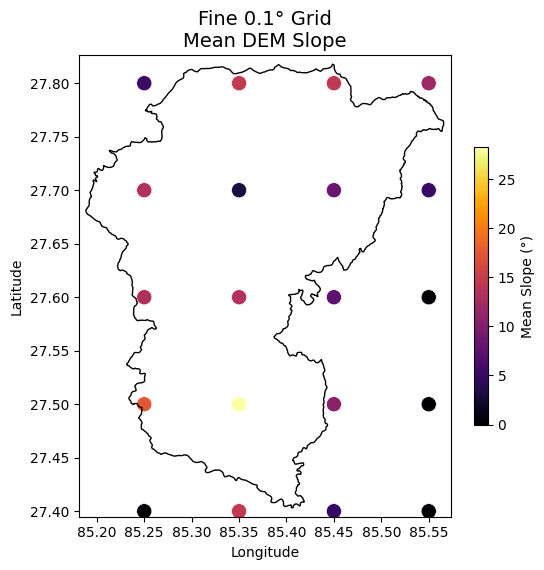

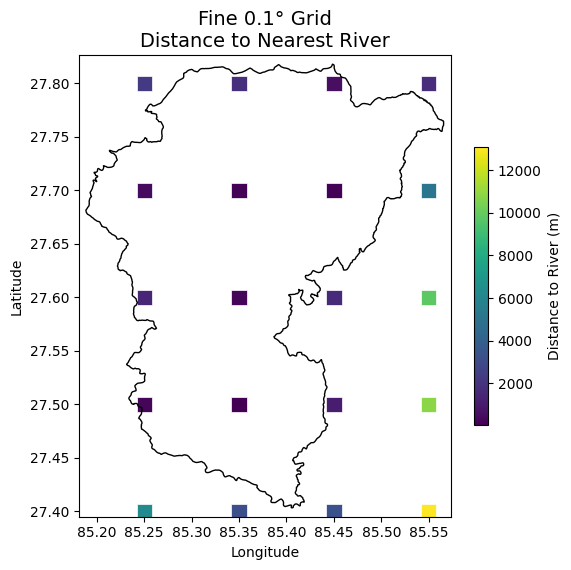

<ipython-input-21-c1fcf47cda56>:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


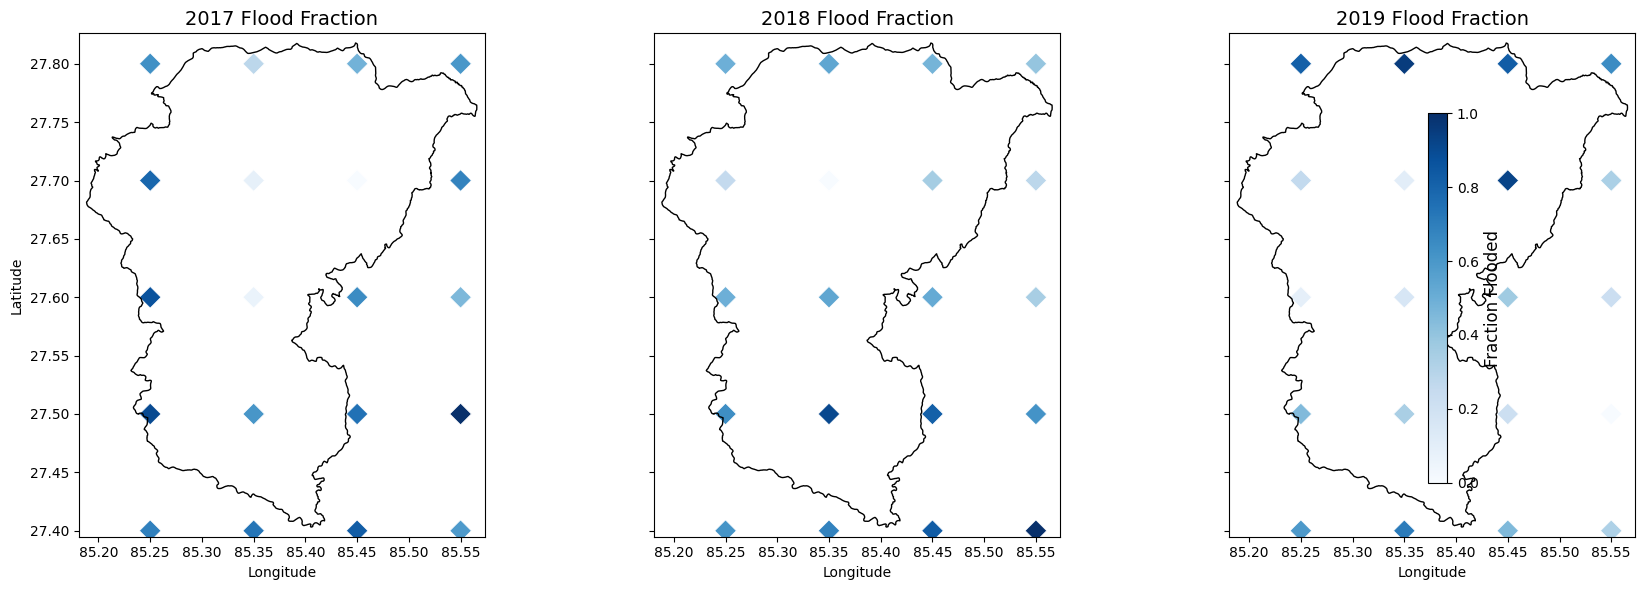

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# 1) Rebuild GeoDataFrame of unique 0.1° centers
df_pts = final_fine[['lat_center','lon_center']].drop_duplicates().reset_index(drop=True)
gf_pts = gpd.GeoDataFrame(
    df_pts,
    geometry=[Point(lon, lat) for lat, lon in zip(df_pts.lat_center, df_pts.lon_center)],
    crs='EPSG:4326'
)

# 2) Merge in static features
gf_static = gf_pts.merge(static_df, on=['lat_center','lon_center'])
gf_river  = gf_pts.merge(pts[['lat_center','lon_center','dist_to_river_m']],
                         on=['lat_center','lon_center'])

# 3) Prepare flood-panel data
years = [2017, 2018, 2019]
gf_flood = {
    yr: gpd.GeoDataFrame(
            final_fine[final_fine.year==yr]
            .drop_duplicates(subset=['lat_center','lon_center']),
            geometry=[Point(lon, lat) for lat, lon in zip(
                final_fine[final_fine.year==yr].lat_center,
                final_fine[final_fine.year==yr].lon_center
            )],
            crs='EPSG:4326'
        )
    for yr in years
}

# 4) Set up axis limits (with a small margin)
minx, miny, maxx, maxy = valley.total_bounds
dx, dy = (maxx-minx)*0.02, (maxy-miny)*0.02
xlim = (minx-dx, maxx+dx)
ylim = (miny-dy, maxy+dy)

# 5) Plot Mean Slope
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
sc1 = gf_static.plot(
    ax=ax, column='mean_slope', cmap='inferno', marker='o',
    edgecolor='white', linewidth=0.5, markersize=120,
    legend=True, legend_kwds={'label':'Mean Slope (°)', 'shrink':0.6}
)
ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_title("Fine 0.1° Grid\nMean DEM Slope", fontsize=14)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.show()

# 6) Plot Distance to River
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
sc2 = gf_river.plot(
    ax=ax, column='dist_to_river_m', cmap='viridis', marker='s',
    edgecolor='white', linewidth=0.5, markersize=120,
    legend=True, legend_kwds={'label':'Distance to River (m)', 'shrink':0.6}
)
ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_title("Fine 0.1° Grid\nDistance to Nearest River", fontsize=14)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.show()

# 7) Flood-Fraction Subplots
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)
for ax, yr in zip(axes, years):
    valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    gf_flood[yr].plot(
        ax=ax, column='frac_flooded', cmap='Blues', marker='D',
        edgecolor='white', linewidth=0.5, markersize=120,
        legend=False
    )
    ax.set_title(f"{yr} Flood Fraction", fontsize=14)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0,1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='vertical',
                    fraction=0.03, pad=0.03, shrink=0.8)
cbar.set_label("Fraction Flooded", fontsize=12)

plt.tight_layout()
plt.show()


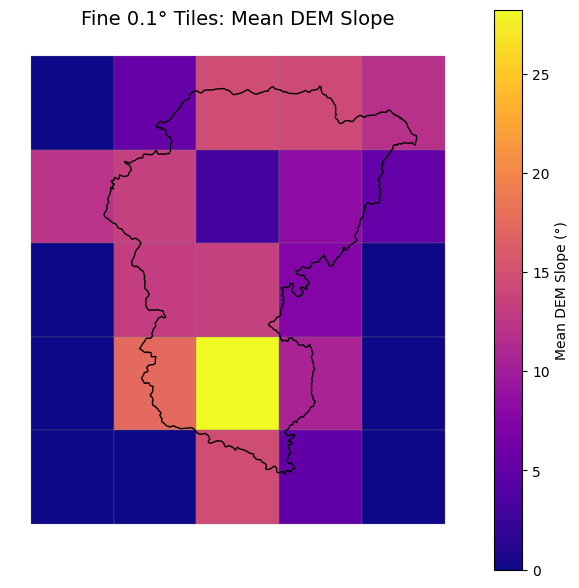

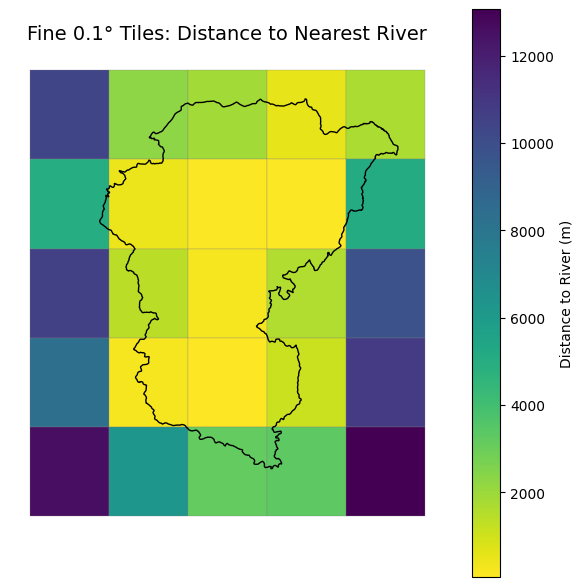

<ipython-input-22-097d3ea6fc43>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


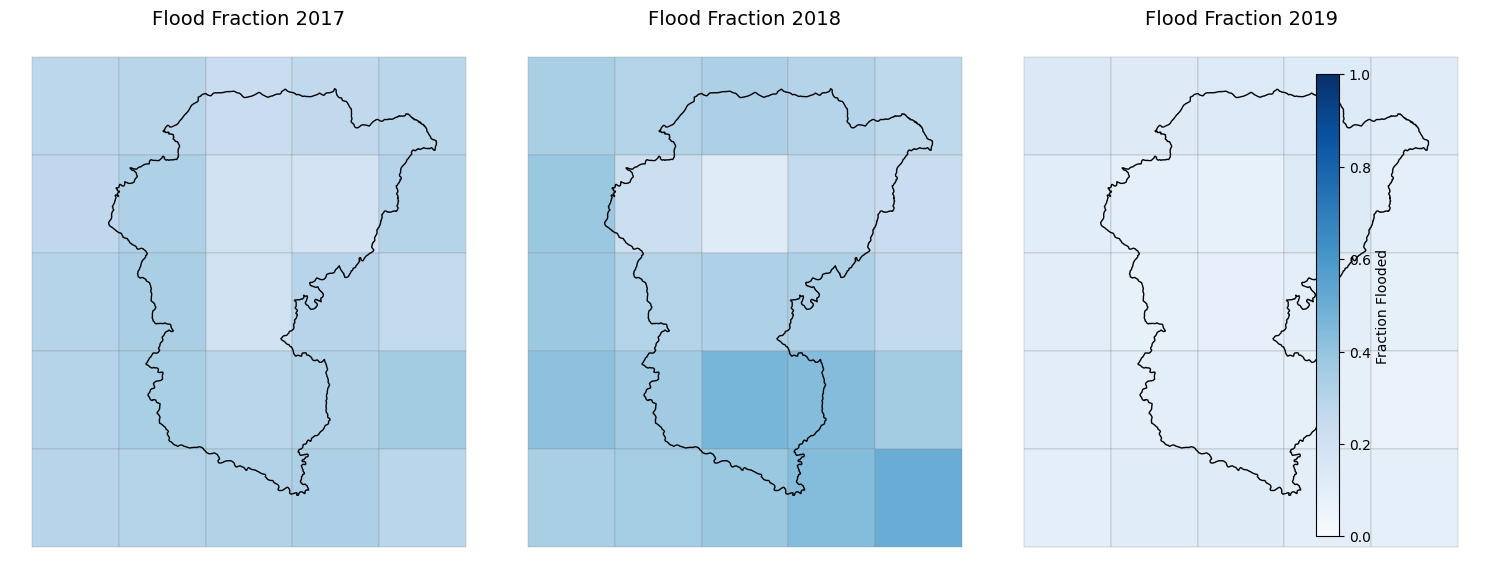

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from shapely.geometry import box
from pathlib import Path

# 1️⃣ Rebuild the 25 tile polygons with static and label attributes

# Merge static slope into tiles_gdf
tiles = tiles_gdf.merge(static_df, on=['lat_center','lon_center'])

# Merge river-distance
tiles = tiles.merge(
    pts[['lat_center','lon_center','dist_to_river_m']],
    on=['lat_center','lon_center']
)

# Prepare annual flood fraction by merging final_fine
# This will duplicate each polygon 3× (one per year)
tiles_flood = tiles.merge(final_fine[['year','lat_center','lon_center','frac_flooded']],
                          on=['lat_center','lon_center'])

# 2️⃣ Plot Static: Mean Slope
fig, ax = plt.subplots(1,1,figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
tiles.plot(
    ax=ax, column='mean_slope',
    cmap='plasma',
    edgecolor='gray',
    linewidth=0.2,
    legend=True,
    legend_kwds={'label': 'Mean DEM Slope (°)'}
)
ax.set_title("Fine 0.1° Tiles: Mean DEM Slope", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 3️⃣ Plot Static: Distance to River
fig, ax = plt.subplots(1,1,figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
tiles.plot(
    ax=ax, column='dist_to_river_m',
    cmap='viridis_r',
    edgecolor='gray',
    linewidth=0.2,
    legend=True,
    legend_kwds={'label': 'Distance to River (m)'}
)
ax.set_title("Fine 0.1° Tiles: Distance to Nearest River", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 4️⃣ Plot Annual Flood Fraction Panels
years = [2017, 2018, 2019]
fig, axes = plt.subplots(1, len(years), figsize=(5*len(years),6), sharey=True)
vmin, vmax = 0.0, 1.0
norm = Normalize(vmin=vmin, vmax=vmax)
for ax, yr in zip(axes, years):
    subset = tiles_flood[tiles_flood.year == yr]
    valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    subset.plot(
        ax=ax, column='frac_flooded',
        cmap='Blues',
        edgecolor='gray',
        linewidth=0.2,
        norm=norm,
        legend=False
    )
    ax.set_title(f"Flood Fraction {yr}", fontsize=14)
    ax.set_axis_off()

# shared colorbar on the right
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm, ax=axes.tolist(),
    orientation='vertical',
    fraction=0.025,
    pad=0.02,
    label='Fraction Flooded'
)
plt.tight_layout()
plt.show()


In [23]:
from pathlib import Path

# Folder where you want to save
static_data_dir = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')

# 1) Fine-grid slope stats
slope_csv_fine = static_data_dir / 'slope_0.1deg.csv'
static_df.to_csv(slope_csv_fine, index=False)

# 2) Fine-grid river-distance
river_csv_fine = static_data_dir / 'dist_to_river_0.1deg.csv'
pts[['lat_center','lon_center','dist_to_river_m']].to_csv(river_csv_fine, index=False)

# 3) Full 0.1° datacube (including flood fractions)
final_csv_fine = static_data_dir / 'datacube_0.1deg.csv'
final_fine.to_csv(final_csv_fine, index=False)

# 4) (Optional) Yearly tile polygons with flood fraction
tiles_flood_geojson = static_data_dir / 'tiles_flood_0.1deg.geojson'
tiles_flood.to_file(tiles_flood_geojson, driver='GeoJSON')

# Print out what we wrote
print("Saved fine‐grid outputs:")
print(" •", slope_csv_fine)
print(" •", river_csv_fine)
print(" •", final_csv_fine)
print(" •", tiles_flood_geojson)


Saved fine‐grid outputs:
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/slope_0.1deg.csv
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/dist_to_river_0.1deg.csv
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/datacube_0.1deg.csv
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/tiles_flood_0.1deg.geojson
